# Travail pratique 4
*INF600F - Traitement d'images (H2022, UQÀM)*


## Identification

- Nom : Jacob-Simard
- Prénom : Raphaël
- Code permanent : JACR26038907
- Cours : INF600f - H2022
- Équipe : 9

In [141]:
import imageio
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from skimage import morphology, filters, measure, transform, feature
from sklearn.cluster import KMeans




im1 = imageio.imread("./tp4_ex1.png")
im2 = imageio.imread("./tp4_ex2.tif")

# Importation des modules pertinents ici.
# Assurez-vous d'inclure toute autre fonction que vous
# jugez nécessaires ici






# Exercice 1 : Reconnaissance de texte

In [132]:

def _pretraitement(img: np.ndarray) -> np.ndarray:
    """
    Effectue le prétraitement d'une image. 
    
    Retourne une copie de l'image donnée dont l'intensité à été inversée, les valeur on été transformées en tons de gris et normalisées entre 0 et 1.
    @param
        img : L'image à traiter
    @return
        L'image transformée en grayscale, normalisée et inversée
    """
    img_traite = img.copy()
    if len(img_traite.shape) > 2 :
        # Transformation en grayscale si l'image ne l'est pas déjà
        img_traite = img_traite.mean(axis=2).astype(np.float32)
    # Normalisation de l'image entre 0 et 1
    img_traite = (img_traite - img_traite.min()) / (img_traite.max() - img_traite.min())
    
    # Inversion des intensités
    img_traite = -img_traite + 1.0

    return img_traite

def _trouver_lettres_bordure(img:np.ndarray, seed:np.ndarray) -> np.ndarray:
    prev = None
    curr = seed
    while np.not_equal(prev, curr).any():
        prev = curr.copy()
        curr = np.logical_and(img, morphology.binary_dilation(curr))

    return curr

def _segmentation(img:np.ndarray) -> tuple[np.ndarray, int]:
    traite = _pretraitement(img)
    seg = morphology.closing(traite)



    otsu = filters.threshold_otsu(seg)
    seg[ seg <= otsu]  = 0.0
    seg[seg > otsu] = 1.0

    bordure = seg.copy()
    bordure[1:-1, 1:-1] = 0.0
    lettres = _trouver_lettres_bordure(seg, bordure)

    seg = (seg - lettres).astype(int)
    labels, num = measure.label(seg, return_num = True)


    return labels, num

def _extraction(labels: np.ndarray, nbr_label:int) -> list[np.ndarray]:
    lettres = []
    for lettre in range(1, nbr_label):
        curr_label = labels.copy()
        curr_label[curr_label != lettre] = 0
        curr_label[curr_label == lettre] = 1
        i, j = np.where(curr_label == 1)
        curr_label = curr_label[i.min():i.max()+1, j.min():j.max()+1]
        
        curr_label = np.pad(curr_label, 3)

        curr_label = transform.resize(curr_label, (72,72), mode="constant", cval = 0, anti_aliasing=True)

        curr_label = transform.downscale_local_mean(curr_label, (3,3))

        plt.show()
        lettres.append(curr_label)
    return lettres
        





def display_randomImages(coll_img : list[np.ndarray], nbr_a_afficher:int = 12):
    a_afficher = np.random.randint(len(coll_img), size=(nbr_a_afficher))
    nbr_lignes = ceil(nbr_a_afficher / 4) if nbr_a_afficher > 4 else 1
    nbr_colonnes = 4 if nbr_lignes > 1 else nbr_a_afficher
    curr = 1
    plt.figure(figsize=(15,15))
    for elem in a_afficher:
        plt.subplot(nbr_lignes, nbr_colonnes, curr)
        plt.title(f"lettre {elem}")
        plt.imshow(coll_img[elem])
        curr += 1
    plt.show()




706


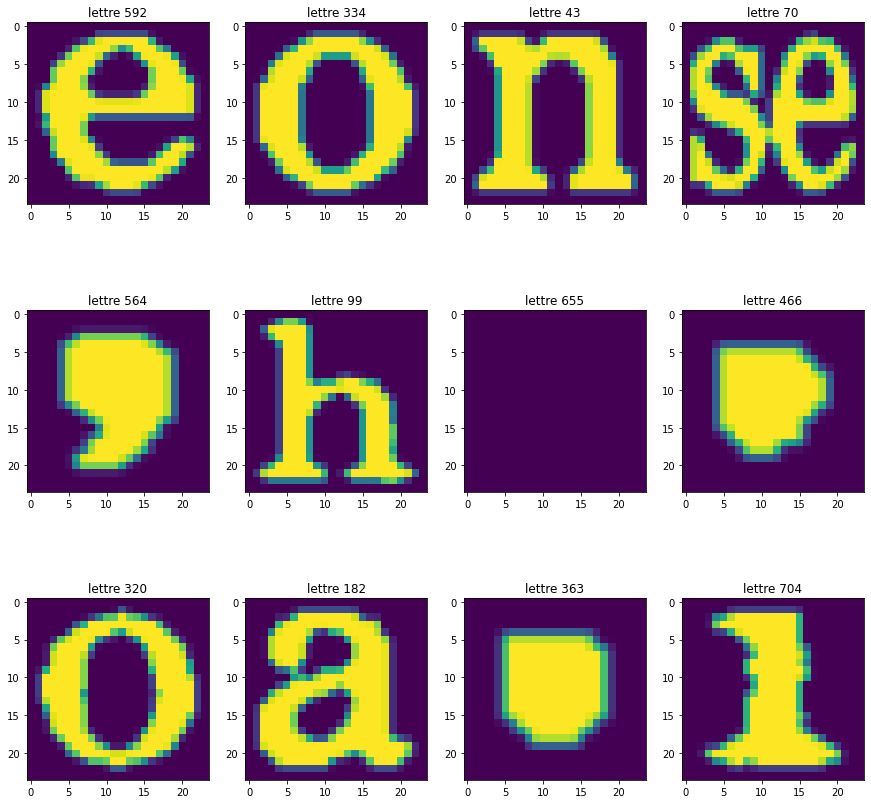

[[5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20
  5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20
  5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20
  5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20
  5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20
  5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20]
 [5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20
  5.42101086e-20 5.42101086e-20 5.42101086e-20 5.87926847e-20
  9.38847136e-20 1.15291758e-19 7.39044961e-20 5.46446633e-20
  5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20
  5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20
  5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20]
 [5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20
  5.42101086e-20 5.42101086e-20 5.42101086e-20 8.33229447e-20
  1.62630326e-19 1.62630326e-19 1.42552508e-19 5.69708086e-20
  5.42101086e-20 5.42101086e-20 5.42101086e-20 5.42101086e-20
  5.42

In [146]:
seg, num = _segmentation(im1)
coll_lettres = _extraction(seg, num)
display_randomImages(coll_lettres)





#### Question : Combien de lettres avez-vous détectées dans cette image?

706

#### Question : En observant les lettres segmentées, pouvez-vous identifier des situations pour lesquelles le pipeline de traitement d’images proposé plus haut échoue à extraire une lettre isolée ? Que suggérez-vous pour améliorer les performances de l’extraction des lettres ?

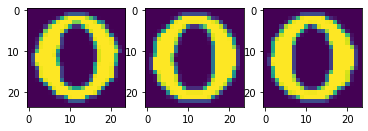

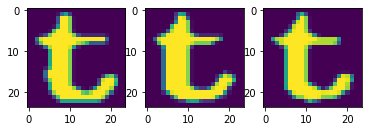

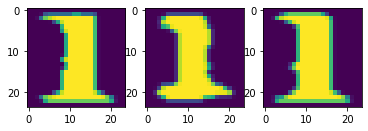

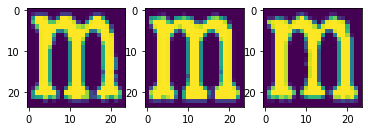

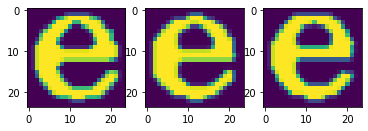

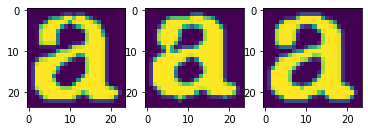

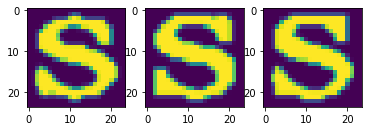

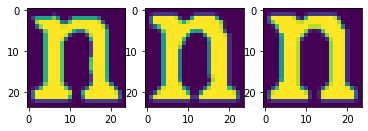

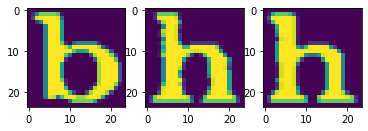

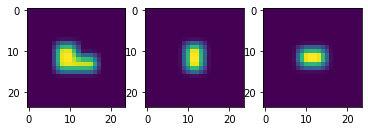

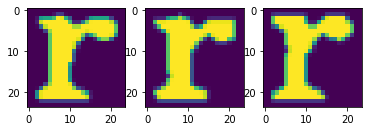

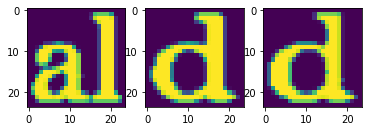

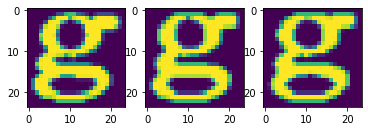

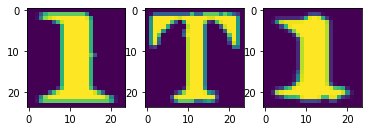

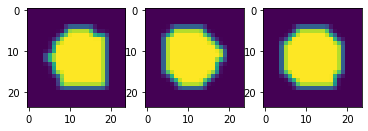

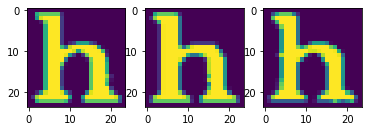

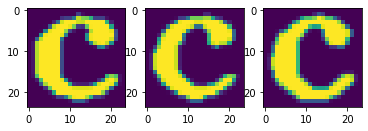

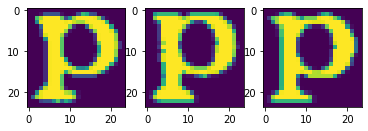

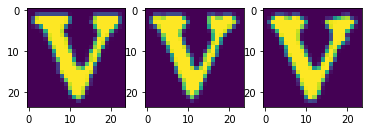

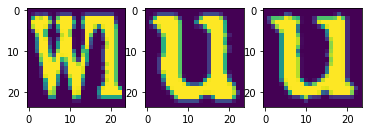

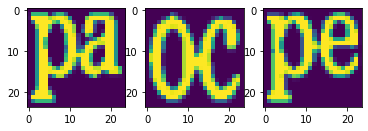

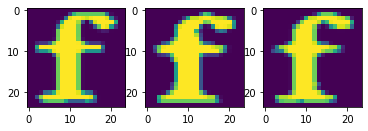

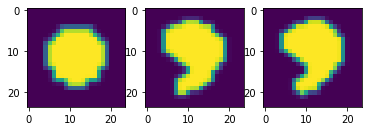

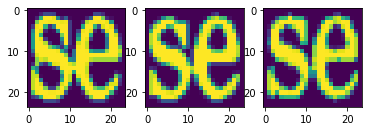

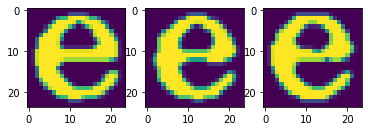

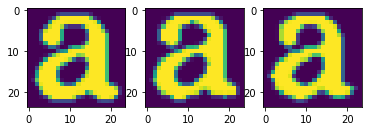

In [150]:
# KMean

attr = []
for img in coll_lettres:
    attr.append(feature.hog(img))

modele = KMeans(n_clusters=26).fit(attr)

classes = [[] for _ in range(27)]
for i in range(len(modele.labels_)):
    classes[modele.labels_[i]].append(coll_lettres[i])

for elem in classes:
    if elem:
        curr = 1
        for nbr in range(len(elem)):
            plt.subplot(1,len(elem),curr)
            plt.imshow(elem[nbr])
            curr +=1
        plt.show()

# Exercice 2 : Compter des cellules

In [135]:
# Ajouter ici des cellules de code / markdown pour vos réponses